<a href="https://colab.research.google.com/github/pradakshina12/FoodRecognitionandCaloriePrediction/blob/main/FoodRecognitionAndCalorieEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'food-101:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F8544%2F11959%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240507%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240507T151054Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3697b1e751fb1a1d852a53ad1b5cbefb21f7a7ee5863d3eaa38bf0b682bb9ea3413e19340e027e068ae6bb3532ce4441e67f6b7e5fb9f8777799e2f5696fd04be3161f0d99a3c3fa12a9c76f69c209d3098ff7d7eb9ce3acb82ae7b438b214721781c14a07d9977645473c917beeb66cf6271c91397e48781d39012cd90775b1b4a0fd1d5165432daa95eace339eb632e33abda85db02025f0bffc07d7ff18dc2e77edd52d7f310be67a49e0a90a6728377746b7d84b0665120a14940a70946b285eabe2a451c5c90ed487df8c4cea8fc6ededfadedc0f8ccf164c7c926fe5b775cf704ffe5f28787ef663611758aafd0d78b775285d54d200918556bbe7a771,food41:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1864%2F33884%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240507%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240507T151054Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4600089249e20ec04ce446a7814d0e088eecea70d6376139c3ad0d2747d0403a68a0d5be5be9ffa8611d9c8a2291d51b896466c1908259b7a5da439394199a38064d7c42c0472137e2d17b9c461ad24d3c239bc6bf6be87de528c92e89a87f936d709f490eb132433ff27b498ee6701afc727c6624586a60ff537fed15b95f08790df0d1cb887b72606862c6277fb777ac73474b6f5a232f1bf4feb4d89b6864909b5d0789c350eb4547ff97d5b3b86535779513f9b24ca235ce111903116a6bfc33e955c356147e66c0060b91e31c55562c502b85198b87239b520f3a327571b7f795806faff186dae3c3370a473eb1798771d0daac5993821668248734a193,food-101-model/tensorflow2/food-101/1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-models-data%2F11442%2F13821%2Fbundle%2Farchive.tar.gz%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240507%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240507T151054Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1b7aba14a5f588cb7353c51133880fef7d2769f2b091b0b8d065475c37acc6a812667822929271a4dba9162986685c4cd49bbe3566e71853c819896e38f18728ff04c49da5c51ca338988fb012d47e176bc65d944768ece2b6ae2662eea1bdda417f2bff87e12555ea90ea3314ab53fa642a80d80cfd98708eb769bb74eb38be306bd28dfa60aa660e98313f5a6754e88aa20d421529d0ab206b999efaf509a502c26dbf2fe5f2eeec27f54da444120db17fbcd4c3b4f02c9110ed5c176c5dd5ced0cda80d2f6ae560ede9138e6c7ca0ad59d9b0861c28ec19b737de330a03e62ec59298794b34576a62bf39a89fe2a9269759f14288ba64f77969ffd86da12b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 10067059132 bytes downloaded
Downloaded and uncompressed: food-101
[==================================================] 5693808106 bytes downloaded
Downloaded and uncompressed: food41
[==================================================] 168642609 bytes downloaded
Downloaded and uncompressed: food-101-model/tensorflow2/food-101/1
Data source import complete.


In [ ]:
import keras
keras.__version__

'2.15.0'

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from keras.src.layers.pooling.average_pooling2d import AvgPool2D
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout
from keras.models import Sequential
from keras.layers import Dense,Input,Flatten
from tensorflow.keras.utils import load_img,img_to_array
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
import os
print(os.listdir("/kaggle/input/food-101/food-101/food-101/images/"))

['fried_rice', 'beef_tartare', 'bibimbap', 'falafel', 'chocolate_mousse', 'breakfast_burrito', 'seaweed_salad', 'hamburger', 'cheese_plate', 'greek_salad', 'panna_cotta', 'creme_brulee', 'chicken_quesadilla', 'guacamole', 'baklava', 'caesar_salad', 'shrimp_and_grits', 'sashimi', 'chicken_curry', 'pulled_pork_sandwich', 'hummus', 'baby_back_ribs', 'fried_calamari', 'carrot_cake', 'donuts', 'poutine', 'beet_salad', 'spaghetti_carbonara', 'ice_cream', 'chocolate_cake', 'tacos', 'samosa', 'huevos_rancheros', 'garlic_bread', 'crab_cakes', 'spring_rolls', 'frozen_yogurt', 'ramen', 'tiramisu', 'strawberry_shortcake', 'ceviche', 'paella', 'lasagna', 'lobster_roll_sandwich', 'prime_rib', 'fish_and_chips', 'eggs_benedict', 'steak', 'hot_dog', 'hot_and_sour_soup', '.DS_Store', 'takoyaki', 'gnocchi', 'pad_thai', 'foie_gras', 'tuna_tartare', 'clam_chowder', 'french_toast', 'nachos', 'beef_carpaccio', 'beignets', 'cannoli', 'dumplings', 'croque_madame', 'grilled_salmon', 'ravioli', 'pizza', 'french_

---

Food Classes

In [ ]:
values = ['macarons', 'french_toast', 'lobster_bisque', 'prime_rib', 'pork_chop', 'guacamole', 'baby_back_ribs', 'mussels', 'beef_carpaccio', 'poutine', 'hot_and_sour_soup', 'seaweed_salad', 'foie_gras', 'dumplings', 'peking_duck', 'takoyaki', 'bibimbap', 'falafel', 'pulled_pork_sandwich', 'lobster_roll_sandwich', 'carrot_cake', 'beet_salad', 'panna_cotta', 'donuts', 'red_velvet_cake', 'grilled_cheese_sandwich', 'cannoli', 'spring_rolls', 'shrimp_and_grits', 'clam_chowder', 'omelette', 'fried_calamari', 'caprese_salad', 'oysters', 'scallops', 'ramen', 'grilled_salmon', 'croque_madame', 'filet_mignon', 'hamburger', 'spaghetti_carbonara', 'miso_soup', 'bread_pudding', 'lasagna', 'crab_cakes', 'cheesecake', 'spaghetti_bolognese', 'cup_cakes', 'creme_brulee', 'waffles', 'fish_and_chips', 'paella', 'macaroni_and_cheese', 'chocolate_mousse', 'ravioli', 'chicken_curry', 'caesar_salad', 'nachos', 'tiramisu', 'frozen_yogurt', 'ice_cream', 'risotto', 'club_sandwich', 'strawberry_shortcake', 'steak', 'churros', 'garlic_bread', 'baklava', 'bruschetta', 'hummus', 'chicken_wings', 'greek_salad', 'tuna_tartare', 'chocolate_cake', 'gyoza', 'eggs_benedict', 'deviled_eggs', 'samosa', 'sushi', 'breakfast_burrito', 'ceviche', 'beef_tartare', 'apple_pie', '.DS_Store', 'huevos_rancheros', 'beignets', 'pizza', 'edamame', 'french_onion_soup', 'hot_dog', 'tacos', 'chicken_quesadilla', 'pho', 'gnocchi', 'pancakes', 'fried_rice', 'cheese_plate', 'onion_rings', 'escargots', 'sashimi', 'pad_thai', 'french_fries']
values.sort()
values = values[1:]
print(values)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [ ]:
print("Number of classes:",len(values))

Number of classes: 101


In [ ]:
s = """Apple Pie: ~2.5 calories per gram
Baby Back Ribs: ~3.5 calories per gram
Baklava: ~5 calories per gram
Beef Carpaccio: ~2 calories per gram
Beef Tartare: ~2.5 calories per gram
Beet Salad: ~0.5 calories per gram
Beignets: ~3.5 calories per gram
Bibimbap: ~1.5 calories per gram
Bread Pudding: ~2.5 calories per gram
Breakfast Burrito: ~2 calories per gram
Bruschetta: ~1 calorie per gram
Caesar Salad: ~0.5 calories per gram
Cannoli: ~3.5 calories per gram
Caprese Salad: ~1 calorie per gram
Carrot Cake: ~3.5 calories per gram
Ceviche: ~0.5 calories per gram
Cheese Plate: ~3.5 calories per gram
Cheesecake: ~3.5 calories per gram
Chicken Curry: ~1.5 calories per gram
Chicken Quesadilla: ~2.5 calories per gram
Chicken Wings: ~3 calories per gram
Chocolate Cake: ~4 calories per gram
Chocolate Mousse: ~3 calories per gram
Churros: ~4 calories per gram
Clam Chowder: ~1.5 calories per gram
Club Sandwich: ~2.5 calories per gram
Crab Cakes: ~2 calories per gram
Creme Brulee: ~3.5 calories per gram
Croque Madame: ~3 calories per gram
Cupcakes: ~3.5 calories per gram
Deviled Eggs: ~1 calorie per gram
Donuts: ~4 calories per gram
Dumplings: ~2.5 calories per gram
Edamame: ~1 calorie per gram
Eggs Benedict: ~2.5 calories per gram
Escargots: ~1 calorie per gram
Falafel: ~2 calories per gram
Filet Mignon: ~2.5 calories per gram
Fish and Chips: ~2.5 calories per gram
Foie Gras: ~4.5 calories per gram
French Fries: ~3.5 calories per gram
French Onion Soup: ~1 calorie per gram
French Toast: ~2 calories per gram
Fried Calamari: ~2.5 calories per gram
Fried Rice: ~1.5 calories per gram
Frozen Yogurt: ~1 calorie per gram
Garlic Bread: ~4 calories per gram
Gnocchi: ~1.5 calories per gram
Greek Salad: ~0.5 calories per gram
Grilled Cheese Sandwich: ~3 calories per gram
Grilled Salmon: ~2 calories per gram
Guacamole: ~2 calories per gram
Gyoza: ~2 calories per gram
Hamburger: ~3.5 calories per gram
Hot and Sour Soup: ~0.5 calories per gram
Hot Dog: ~3.5 calories per gram
Huevos Rancheros: ~2 calories per gram
Hummus: ~1.5 calories per gram
Ice Cream: ~2 calories per gram
Lasagna: ~1.5 calories per gram
Lobster Bisque: ~1 calorie per gram
Lobster Roll Sandwich: ~2.5 calories per gram
Macaroni and Cheese: ~3 calories per gram
Macarons: ~4 calories per gram
Miso Soup: ~0.5 calories per gram
Mussels: ~0.5 calories per gram
Nachos: ~2.5 calories per gram
Omelette: ~1.5 calories per gram
Onion Rings: ~2.5 calories per gram
Oysters: ~0.5 calories per gram
Pad Thai: ~2 calories per gram
Paella: ~1.5 calories per gram
Pancakes: ~2 calories per gram
Panna Cotta: ~3.5 calories per gram
Peking Duck: ~4 calories per gram
Pho: ~1 calorie per gram
Pizza: ~2.5 calories per gram
Pork Chop: ~2.5 calories per gram
Poutine: ~2.5 calories per gram
Prime Rib: ~2.5 calories per gram
Pulled Pork Sandwich: ~2.5 calories per gram
Ramen: ~1 calorie per gram
Ravioli: ~1.5 calories per gram
Red Velvet Cake: ~4 calories per gram
Risotto: ~1.5 calories per gram
Samosa: ~2 calories per gram
Sashimi: ~1 calorie per gram
Scallops: ~1 calorie per gram
Seaweed Salad: ~0.5 calories per gram
Shrimp and Grits: ~2 calories per gram
Spaghetti Bolognese: ~1.5 calories per gram
Spaghetti Carbonara: ~2 calories per gram
Spring Rolls: ~1.5 calories per gram
Steak: ~2.5 calories per gram
Strawberry Shortcake: ~3.5 calories per gram
Sushi: ~1 calorie per gram
Tacos: ~2 calories per gram
Takoyaki: ~2.5 calories per gram
Tiramisu: ~3 calories per gram
Tuna Tartare: ~1.5 calories per gram
Waffles: ~2 calories per gram
"""
calories = s.splitlines()
s = "These values are approximations and can vary based on factors such as ingredients and cooking methods."

In [ ]:
len(calories)

101

In [ ]:
calories[0]

'Apple Pie: ~2.5 calories per gram'

In [ ]:
print("First element:",values[0],"\nLast element:",values[-1])

First element: apple_pie 
Last element: waffles


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.1)
train_data = train_datagen.flow_from_directory('/kaggle/input/food-101/food-101/food-101/images/',
                                               target_size=(224,224),
                                               batch_size=100,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training')
test_data = train_datagen.flow_from_directory('/kaggle/input/food-101/food-101/food-101/images/',
                                               target_size=(224,224),
                                               batch_size=100,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')

Found 90900 images belonging to 101 classes.
Found 10100 images belonging to 101 classes.


In [ ]:
print("Images Shape:",train_data.image_shape)

Images Shape: (224, 224, 3)


In [ ]:
print('\nBatch Size:',100,
     "\nNunmber of Batches in training set:",len(train_data),
     "\nNunmber of Batches in testing set:",len(test_data),
     "\nNumber of Samples in training set:",train_data.samples,"Samples",
     "\nNumber of Samples in testing set:",test_data.samples,"Samples")


Batch Size: 100 
Nunmber of Batches in training set: 909 
Nunmber of Batches in testing set: 101 
Number of Samples in training set: 90900 Samples 
Number of Samples in testing set: 10100 Samples


In [ ]:
print("\nThe 101 Classes numbers:\n",np.unique(train_data.labels),"\n",
       "_"*30,
       "\nThe 101 classes names:\n",train_data.class_indices,
      sep="")


The 101 Classes numbers:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]
______________________________
The 101 classes names:
{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheese_plate': 16, 'cheesecake': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cake

In [ ]:
train_data.image_shape

(224, 224, 3)

In [ ]:
np.unique(train_data.labels)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int32)

In [ ]:
np.unique(test_data.labels)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int32)

In [ ]:
train_data.class_indices

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4,
 'beet_salad': 5,
 'beignets': 6,
 'bibimbap': 7,
 'bread_pudding': 8,
 'breakfast_burrito': 9,
 'bruschetta': 10,
 'caesar_salad': 11,
 'cannoli': 12,
 'caprese_salad': 13,
 'carrot_cake': 14,
 'ceviche': 15,
 'cheese_plate': 16,
 'cheesecake': 17,
 'chicken_curry': 18,
 'chicken_quesadilla': 19,
 'chicken_wings': 20,
 'chocolate_cake': 21,
 'chocolate_mousse': 22,
 'churros': 23,
 'clam_chowder': 24,
 'club_sandwich': 25,
 'crab_cakes': 26,
 'creme_brulee': 27,
 'croque_madame': 28,
 'cup_cakes': 29,
 'deviled_eggs': 30,
 'donuts': 31,
 'dumplings': 32,
 'edamame': 33,
 'eggs_benedict': 34,
 'escargots': 35,
 'falafel': 36,
 'filet_mignon': 37,
 'fish_and_chips': 38,
 'foie_gras': 39,
 'french_fries': 40,
 'french_onion_soup': 41,
 'french_toast': 42,
 'fried_calamari': 43,
 'fried_rice': 44,
 'frozen_yogurt': 45,
 'garlic_bread': 46,
 'gnocchi': 47,
 'greek_salad': 48,
 'grilled_cheese_sa

---

 Model  - Inception V3 Architecture



In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math

In [ ]:
base_model3 = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

x = base_model3.output
x = AveragePooling2D()(x)
x = Dropout(.5)(x)
x = Flatten()(x)
x = Dense(101, kernel_initializer='glorot_uniform', kernel_regularizer=l2(.0005), activation='softmax')(x)
model3 = Model(inputs=base_model3.input, outputs=x)
model3.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [ ]:
opt = SGD(lr=.1, momentum=.9)
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.models import load_model
model3 = load_model("/kaggle/input/food-101-model/tensorflow2/food-101/1/model_food_101.h5")

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
results3 = model3.fit(train_data, epochs=10, validation_data=test_data,
                  steps_per_epoch=len(train_data), validation_steps=len(test_data),
                  callbacks = EarlyStopping(patience=2, monitor='val_accuracy',restore_best_weights=True)
                  )

Epoch 1/10
909/909 [==============================] - 840s 890ms/step - loss: 0.0781 - accuracy: 0.9936 - val_loss: 1.5083 - val_accuracy: 0.7377
Epoch 2/10
909/909 [==============================] - 810s 890ms/step - loss: 0.0674 - accuracy: 0.9953 - val_loss: 1.4155 - val_accuracy: 0.7512
Epoch 3/10
909/909 [==============================] - 805s 885ms/step - loss: 0.0561 - accuracy: 0.9970 - val_loss: 1.4076 - val_accuracy: 0.7496
Epoch 4/10
909/909 [==============================] - 805s 886ms/step - loss: 0.0470 - accuracy: 0.9983 - val_loss: 1.3433 - val_accuracy: 0.7579
Epoch 5/10
909/909 [==============================] - 806s 886ms/step - loss: 0.0385 - accuracy: 0.9994 - val_loss: 1.2409 - val_accuracy: 0.7670
Epoch 6/10
909/909 [==============================] - 805s 885ms/step - loss: 0.0327 - accuracy: 0.9997 - val_loss: 1.1960 - val_accuracy: 0.7724
Epoch 7/10
909/909 [==============================] - 806s 887ms/step - loss: 0.0280 - accuracy: 0.9998 - val_loss: 1.1484 -

In [ ]:
loss, acc = model3.evaluate(test_data)

101/101 [==============================] - 56s 545ms/step - loss: 1.0761 - accuracy: 0.7802


In [ ]:
print("Test Accuracy:",round(acc*100,2),"%","\nTest Loss:",loss)

Test Accuracy: 78.02 % 
Test Loss: 1.0760761499404907


In [ ]:
model = model3

In [ ]:
print("Test Accuracy:",round(acc*100,2),"%","\nTest Loss:",round(loss,4))

Test Accuracy: 78.02 % 
Test Loss: 1.0761


In [ ]:
results3 = {"accuracy":    [0.9924,0.9962,0.9970,0.9986,0.9995,0.9997,0.9997,0.9999,0.9999,1.0000,0.9999,1.0000,1.0000],
            "loss":        [0.0816,0.0646,0.0562,0.0460,0.0379,0.0325,0.0284,0.0245,0.0216,0.0191,0.0173,0.0158,0.0145],
            "val_accuracy":[0.7065,0.7417,0.7487,0.7535,0.7697,0.7693,0.7716,0.7722,0.7721,0.7736,0.7749,0.7743,0.7733],
            "val_loss":    [1.6280,1.4801,1.4059,1.3613,1.2399,1.2145,1.1774,1.1357,1.1133,1.0886,1.0761,1.0645,1.0611]}

In [ ]:
model3.save("model_food_1012.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
results3['val_accuracy']

[0.7065,
 0.7417,
 0.7487,
 0.7535,
 0.7697,
 0.7693,
 0.7716,
 0.7722,
 0.7721,
 0.7736,
 0.7749,
 0.7743,
 0.7733]

In [ ]:
results3['val_loss']

[1.628,
 1.4801,
 1.4059,
 1.3613,
 1.2399,
 1.2145,
 1.1774,
 1.1357,
 1.1133,
 1.0886,
 1.0761,
 1.0645,
 1.0611]

In [ ]:
i = results3['val_loss'].index(round(loss,4))
i

10

In [ ]:
results3['val_accuracy'][i]

0.7749

**Visualize training history**

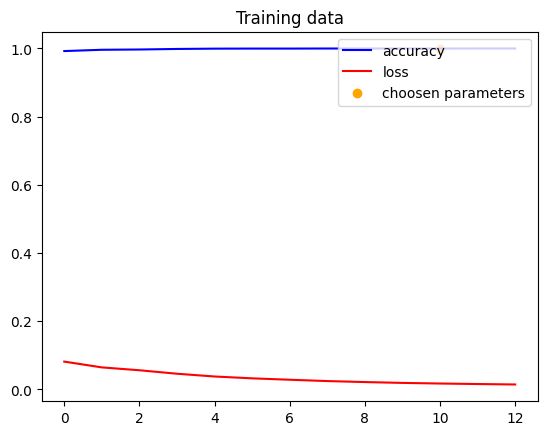

In [ ]:
fig = plt.figure()
plt.plot(results3['accuracy'], c='blue', label='accuracy')
plt.plot(results3['loss'], c='red', label='loss')
plt.scatter(i,results3['accuracy'][i], c='orange', marker='o', label='choosen parameters')
plt.title('Training data')
plt.legend(loc='upper right')
plt.show()

**Visualize testing history**

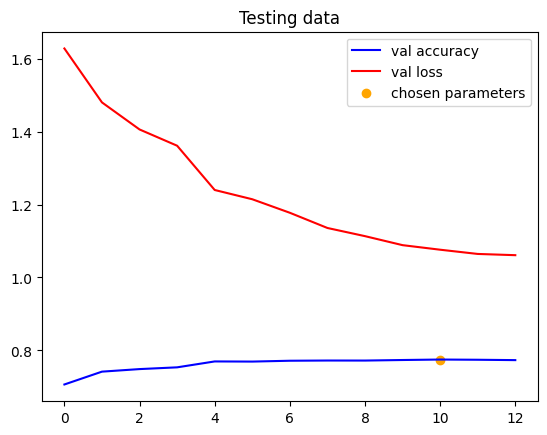

In [ ]:
fig = plt.figure()
plt.plot(results3['val_accuracy'], c='blue', label='val accuracy')
plt.plot(results3['val_loss'], c='red', label='val loss')
plt.scatter(i, results3['val_accuracy'][i], c='orange', marker='o', label='chosen parameters')
plt.title('Testing data')
plt.legend()
plt.show()


In [ ]:
yp = model3.predict(test_data).argmax(axis=1).reshape(-1,)
yp.shape

101/101 [==============================] - 44s 415ms/step


(10100,)

In [ ]:
print(os.listdir("/kaggle/input/food-101/food-101/food-101/images/"))

['fried_rice', 'beef_tartare', 'bibimbap', 'falafel', 'chocolate_mousse', 'breakfast_burrito', 'seaweed_salad', 'hamburger', 'cheese_plate', 'greek_salad', 'panna_cotta', 'creme_brulee', 'chicken_quesadilla', 'guacamole', 'baklava', 'caesar_salad', 'shrimp_and_grits', 'sashimi', 'chicken_curry', 'pulled_pork_sandwich', 'hummus', 'baby_back_ribs', 'fried_calamari', 'carrot_cake', 'donuts', 'poutine', 'beet_salad', 'spaghetti_carbonara', 'ice_cream', 'chocolate_cake', 'tacos', 'samosa', 'huevos_rancheros', 'garlic_bread', 'crab_cakes', 'spring_rolls', 'frozen_yogurt', 'ramen', 'tiramisu', 'strawberry_shortcake', 'ceviche', 'paella', 'lasagna', 'lobster_roll_sandwich', 'prime_rib', 'fish_and_chips', 'eggs_benedict', 'steak', 'hot_dog', 'hot_and_sour_soup', '.DS_Store', 'takoyaki', 'gnocchi', 'pad_thai', 'foie_gras', 'tuna_tartare', 'clam_chowder', 'french_toast', 'nachos', 'beef_carpaccio', 'beignets', 'cannoli', 'dumplings', 'croque_madame', 'grilled_salmon', 'ravioli', 'pizza', 'french_

Macarons Sample


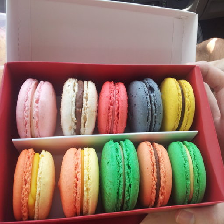

In [ ]:
print("Macarons Sample")
macarons = load_img("/kaggle/input/food-101/food-101/food-101/images/macarons/2428554.jpg",target_size=(224,224))
macarons

Pizza Sample


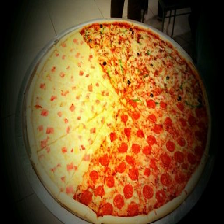

In [ ]:
print("Pizza Sample")
pizza = load_img("/kaggle/input/food-101/food-101/food-101/images/pizza/768276.jpg",target_size=(224,224,3))
pizza

Donuts Sample


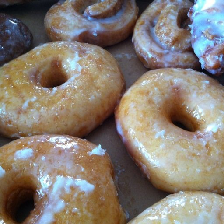

In [ ]:
print("Donuts Sample")
donuts = load_img("/kaggle/input/food-101/food-101/food-101/images/donuts/2563686.jpg",target_size=(224,224,3))
donuts

Frensh Toast Sample


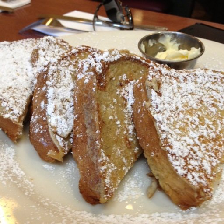

In [ ]:
print("Frensh Toast Sample")
toast = load_img("/kaggle/input/food-101/food-101/food-101/images/french_toast/2769309.jpg",target_size=(224,224,3))
toast

French_fries Sample


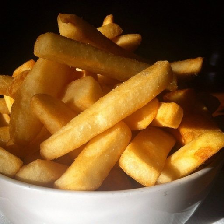

In [ ]:
print("French_fries Sample")
fries = load_img("/kaggle/input/food-101/food-101/food-101/images/french_fries/2246621.jpg",target_size=(224,224))
fries

Ice Cream Sample


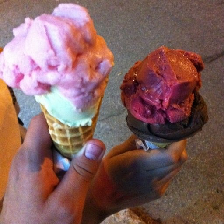

In [ ]:
print("Ice Cream Sample")
ice = load_img("/kaggle/input/food-101/food-101/food-101/images/ice_cream/579407.jpg",target_size=(224,224))
ice

Text(0.5, 1.0, 'Donuts')

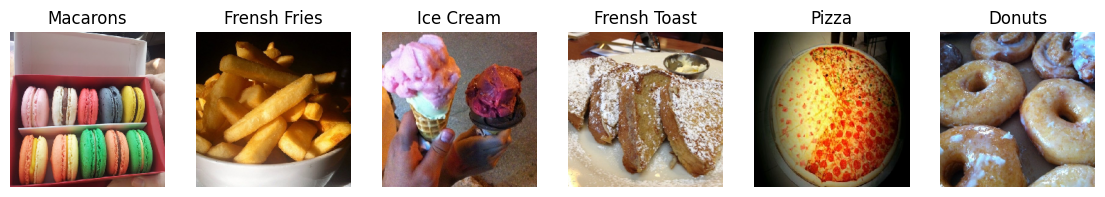

In [ ]:
fig = plt.figure(figsize=(14,7))
# plt.grid=False
fig.add_subplot(1, 6, 1)
plt.axis('off')
plt.imshow(macarons)
plt.title("Macarons")
# _____________________________________________
fig.add_subplot(1, 6, 2)
plt.axis('off')
plt.imshow(fries)
plt.title("Frensh Fries")
# _____________________________________________
fig.add_subplot(1, 6, 3)
plt.axis('off')
plt.imshow(ice)
plt.title("Ice Cream")
# _____________________________________________
fig.add_subplot(1, 6, 4)
plt.axis('off')
plt.imshow(toast)
plt.title("Frensh Toast")
# _____________________________________________
fig.add_subplot(1, 6, 5)
plt.axis('off')
plt.imshow(pizza)
plt.title("Pizza")
# _____________________________________________
fig.add_subplot(1, 6, 6)
plt.axis('off')
plt.imshow(donuts)
plt.title("Donuts")

In [ ]:
macarons = img_to_array(macarons)
fries = img_to_array(fries)
ice = img_to_array(ice)
pizza = img_to_array(pizza)
donuts = img_to_array(donuts)
toast = img_to_array(toast)
macarons = macarons/255
fries = fries/255
ice = ice/255
pizza = pizza/255
donuts = donuts/255
toast = toast/255
macarons = macarons.reshape(1,224,224,3)
fries = fries.reshape(1,224,224,3)
ice = ice.reshape(1,224,224,3)
pizza = pizza.reshape(1,224,224,3)
donuts = donuts.reshape(1,224,224,3)
toast = toast.reshape(1,224,224,3)

macarons.shape

(1, 224, 224, 3)

In [ ]:
p1 = (model.predict(macarons)).argmax()

print("Class ",p1,": ",values[p1],sep='')
print(calories[p1],'\nNote:',s)

1/1 [==============================] - 4s 4s/step
Class 63: macarons
Macarons: ~4 calories per gram 
Note: These values are approximations and can vary based on factors such as ingredients and cooking methods.


In [ ]:
p2 = (model.predict(fries)).argmax()

print("Class ",p2,": ",values[p2],sep='')
print(calories[p2],'\nNote:',s)

1/1 [==============================] - 0s 31ms/step
Class 40: french_fries
French Fries: ~3.5 calories per gram 
Note: These values are approximations and can vary based on factors such as ingredients and cooking methods.


In [ ]:
p3 = (model.predict(ice)).argmax()

print("Class ",p3,": ",values[p3],sep='')
print(calories[p3],'\nNote:',s)

1/1 [==============================] - 0s 38ms/step
Class 58: ice_cream
Ice Cream: ~2 calories per gram 
Note: These values are approximations and can vary based on factors such as ingredients and cooking methods.


In [ ]:
p4 = (model.predict(pizza)).argmax()

print("Class ",p4,": ",values[p4],sep='')
print(calories[p4],'\nNote:',s)

1/1 [==============================] - 0s 27ms/step
Class 76: pizza
Pizza: ~2.5 calories per gram 
Note: These values are approximations and can vary based on factors such as ingredients and cooking methods.


In [ ]:
p5 = (model.predict(donuts)).argmax()

print("Class ",p5,": ",values[p5],sep='')
print(calories[p5],'\nNote:',s)

1/1 [==============================] - 0s 28ms/step
Class 31: donuts
Donuts: ~4 calories per gram 
Note: These values are approximations and can vary based on factors such as ingredients and cooking methods.


In [ ]:
p6 = (model.predict(toast)).argmax()

print("Class ",p6,": ",values[p6],sep='')
print(calories[p6],'\nNote:',s)

1/1 [==============================] - 0s 48ms/step
Class 42: french_toast
French Toast: ~2 calories per gram 
Note: These values are approximations and can vary based on factors such as ingredients and cooking methods.


---